# HIGH VALUE CUSTOMER IDENTIFICATION

## PLANNING OF SOLUCTION

##### INPUT

1. Business Problems:
 - Selecionar os clientes mais valiosos para integrar um programa de fidelização

 2. Dataset:
 - Vendas de um e-commerce online, durante o periodo de um ano.

##### OUTPUT



1. A indicação de pessoas que farão parte do programa:


| Customers| Elegible   |
|----------|------------|
| X    | Yes = 1    | 
| Y    | No = 0     | 



2. Relatório com as respostas para as perguntas de negocio:


- Quem são as pessoas elegíveis para participar do programa?
- Quantos customers farão parte do programa?
- Quais as principais caracteristicas desses clientes?
- Qual o percentual de contribuição  do faturamento, vinda dos customers participantes?
- Qual a expectativa de faturamento desse grupo para os proximos meses?
- Quais as condições para um cliente participar do programa?
- Quais as condições para um cliente ser removido do programa?
- Qual a garantia da eficacia do programa para o restante da base?
- Quais ações o squad de marketing pode realizar para aumentar o faturamento?

##### TASKS

1 - Quem são as pessoas elegíveis para participar do programa?
- O que é ser elegivel? O que são clientes de alto valor?
    - Faturamento:
        - Alto Ticket medio;
        - Alto LTV;
        - Baixa recencia;
        - Alto Basket size;
        - Baixa Probabilidade de Churn;
        - Alta previão LTV;
        - Alta propensão de compra.

- Custo:
    - Baixa taxa de devolução.

- Experiência de compra:
    - Média alta das avaliações

        

2 - Quantos customers farão parte do programa?

- Numero Total de clientes;
- (%) Percentual do grupo


3 - Quais as principais caracteristicas desses clientes?

- Caracteristicas unicas do cliente;
- Atributos da Clusterização.


4 - Qual o percentual de contribuição  do faturamento, vinda dos customers participantes?

- Faturamento total do ano;
- Faturamento do grupo.



5 - Qual a expectativa de faturamento desse grupo para os proximos meses?

- LTV do grupo;
- Análise cohort.

6 - Quais as condições para um cliente participar do programa?

- Definir prioridade (Sasonalidade - 1 mes, 3 meses);
- A pessoa precisa ser similar com uma pessoa do grupo.

7 - Quais as condições para um cliente ser removido do programa?

- Definir prioridade (Sasonalidade - 1 mes, 3 meses);
- A pessoa precisa ser desimilar com uma pessoa do grupo.

8 - Qual a garantia da eficacia do programa para o restante da base?

- Teste A/B;
- Teste A/B Bayesiano;
- Teste A/B hipóteses.

9 - Quais ações o squad de marketing pode realizar para aumentar o faturamento?

- Desconto;
- Preferencia de compra;
- Produtos exclusivos;
- Visita a empresa.


# 1.0 - IMPORTS

## 1.1 - LIBRARIES

In [275]:
import pandas               as pd
import numpy                as np
import matplotlib.pyplot    as plt
import plotly.express       as px
import seaborn              as sns
import re
import inflection
import umap.umap_           as umap
from sklearn.cluster        import KMeans
from sklearn.metrics        import silhouette_score
from yellowbrick.cluster    import KElbowVisualizer, SilhouetteVisualizer


## 1.2 - LOAD DATA

In [276]:
df_raw = pd.read_csv('../dataset/data.csv', encoding='latin-1')

## 1.3 - HELPER FUNCTIONS

### 1.3.1 - PLOT DIMENSIONS

In [277]:
sns.set(rc = {'figure.figsize':(13,5)})

### 1.3.2 - NA VOLUMETRY

In [278]:
def nan_volumetry(data):
    df_na = pd.DataFrame()
    df_na['attributes'] = data.columns
    df_na['volumetry'] = ''
    df_na['percentual'] = ''

    for i in df_na.index:
        volumetry = data[df_na.loc[i, 'attributes']].isna().sum()
        percentual = (volumetry / data['customer_id'].count()) * 100
        df_na.loc[i, 'volumetry'] = volumetry
        df_na.loc[i, 'percentual'] = f"{percentual:.2f}%"  

    return df_na

# 2.0 - DATA DESCRIPTION

In [279]:
df2 = df_raw.copy()

## 2.1 - DATA DIMENSION

In [280]:
print('Total of unique features:\n')
print(df2.apply(lambda x: x.nunique()))
print('\nNumber of rows: {}'.format(df2.shape[0]))
print('Number of cols: {}'.format(df2.shape[1]))

Total of unique features:

InvoiceNo      25900
StockCode       4070
Description     4223
Quantity         722
InvoiceDate    23260
UnitPrice       1630
CustomerID      4372
Country           38
dtype: int64

Number of rows: 541909
Number of cols: 8


## 2.2 - RENAME COLUMNS

In [281]:
old_columns = df2.columns
snakecase = lambda x: inflection.underscore(x)
new_columns = list(map(snakecase, old_columns))
df2.columns = new_columns

## 2.3 - DATA TYPES

In [282]:
df2.dtypes

invoice_no       object
stock_code       object
description      object
quantity          int64
invoice_date     object
unit_price      float64
customer_id     float64
country          object
dtype: object

## 2.4 - NAN VOLUMETRY

In [283]:
df2.isna().sum()

invoice_no           0
stock_code           0
description       1454
quantity             0
invoice_date         0
unit_price           0
customer_id     135080
country              0
dtype: int64

In [284]:
nan_volumetry(df2)

,attributes,volumetry,percentual
0,invoice_no,0,0.00%
1,stock_code,0,0.00%
2,description,1454,0.36%
3,quantity,0,0.00%
4,invoice_date,0,0.00%
5,unit_price,0,0.00%
6,customer_id,135080,33.20%
7,country,0,0.00%


### 2.4.1 - DROP NA

In [285]:
df2 = df2.dropna(subset=['description', 'customer_id'])
print('Volumetry of removed data: {}%'.format((1-(df2.shape[0])/ df_raw.shape[0])*100))

Volumetry of removed data: 24.9266943342886%


In [286]:
df2.isna().sum()

invoice_no      0
stock_code      0
description     0
quantity        0
invoice_date    0
unit_price      0
customer_id     0
country         0
dtype: int64

## 2.5 - CHANGE DATA TYPES

In [287]:
df2['invoice_date'] = pd.to_datetime(df2['invoice_date'])
df2['customer_id'] = df2['customer_id'].astype(int)

In [288]:
df2.dtypes

invoice_no              object
stock_code              object
description             object
quantity                 int64
invoice_date    datetime64[ns]
unit_price             float64
customer_id              int64
country                 object
dtype: object

# 3.0 - DESCRIPTIVE STATISTICS

In [289]:
df3 = df2.copy()
num_attributes = df3.select_dtypes(include = ['int64', 'float64'])
cat_attributes = df3.select_dtypes(include = 'object')

## 3.1 - NUMERICAL ATTRIBUTES

In [290]:
#central tendency: median - mean
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T

#dispersion: max, min, std, range, skew, kurtosis
d1 = pd.DataFrame(num_attributes.apply(np.max)).T
d2 = pd.DataFrame(num_attributes.apply(np.min)).T
d3 = pd.DataFrame(num_attributes.apply(np.std)).T
d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T
d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T

#concatenate
df_concat = pd.concat([d2, d1, d4, ct1, ct2, d3, d5, d6]).T.reset_index()
df_concat.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
df_concat


,attributes,min,max,range,mean,median,std,skew,kurtosis
0,quantity,-80995.0,80995.0,161990.0,12.061303,5.00,248.693064,0.182663,94317.563673
1,unit_price,0.0,38970.0,38970.0,3.460471,1.95,69.315077,452.219019,246924.542988
2,customer_id,12346.0,18287.0,5941.0,15287.690570,15152.00,1713.598197,0.029835,-1.179982


### 3.1.1 - NUMERICAL ATTRIBUTES ANALYSIS

- Negative Quantity (Returning products?)
- Unity Price less than zero (Product discount?)

## 3.2 - CATEGORICAL ATTRIBUTES

In [291]:
cat_attributes.columns

Index(['invoice_no', 'stock_code', 'description', 'country'], dtype='object')

### INVOICE NUMBER

We have Invoice Number with letters and numbers, sendo assim iremos padronizar para uma variavel numerica pois se trata de uma ordem de compra.

In [292]:
invoice_letters = df3.loc[df3['invoice_no'].apply(lambda x: bool(re.search('[^0-9]+', x))), :]
invoice_letters

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,country
141,C536379,D,Discount,-1,2010-12-01 09:41:00,27.50,14527,United Kingdom
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,2010-12-01 09:49:00,4.65,15311,United Kingdom
235,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,2010-12-01 10:24:00,1.65,17548,United Kingdom
236,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548,United Kingdom
237,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548,United Kingdom
...,...,...,...,...,...,...,...,...
540449,C581490,23144,ZINC T-LIGHT HOLDER STARS SMALL,-11,2011-12-09 09:57:00,0.83,14397,United Kingdom
541541,C581499,M,Manual,-1,2011-12-09 10:28:00,224.69,15498,United Kingdom
541715,C581568,21258,VICTORIAN SEWING BOX LARGE,-5,2011-12-09 11:57:00,10.95,15311,United Kingdom
541716,C581569,84978,HANGING HEART JAR T-LIGHT HOLDER,-1,2011-12-09 11:58:00,1.25,17315,United Kingdom


Observando que a coluna Quantity indicam numeros negativos, podemos assumir que são dados relacionados a descontos, devolução ou estorno (cancelamento) de mercadorias pois correspondem a quantidade total de ordens com letras.

In [293]:
print('Total records with almost an letter is: {}'.format(len(invoice_letters)))
print('Total of records with negative quantity is: {}'.format(len(invoice_letters.loc[invoice_letters['quantity'] < 0])))

Total records with almost an letter is: 8905
Total of records with negative quantity is: 8905


STOCK CODE

Analise de stocke code com apenas caracteres

In [294]:
df3.loc[df3['stock_code'].apply(lambda x: bool(re.search('^[a-zA-Z]+$', x))), :].sample(10)

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,country
313049,C564435,POST,POSTAGE,-1,2011-08-25 12:05:00,4.41,17676,United Kingdom
328555,565785,POST,POSTAGE,5,2011-09-06 16:57:00,40.00,12461,Switzerland
41761,539957,POST,POSTAGE,6,2010-12-23 12:58:00,18.00,12585,Germany
317545,C564812,D,Discount,-1,2011-08-30 11:45:00,16.67,14527,United Kingdom
118006,546418,M,Manual,24,2011-03-13 10:57:00,0.42,17315,United Kingdom
122397,546866,M,Manual,2,2011-03-17 15:47:00,2.50,14462,United Kingdom
489091,577906,M,Manual,76,2011-11-22 11:51:00,0.29,13268,United Kingdom
355287,567915,POST,POSTAGE,3,2011-09-22 17:15:00,18.00,12579,France
325478,565442,POST,POSTAGE,3,2011-09-04 14:09:00,18.00,12627,Germany
381479,569866,M,Manual,2,2011-10-06 14:50:00,1.25,12757,Portugal


In [295]:
stock_code_letters = df3.loc[df3['stock_code'].apply(lambda x: bool(re.search('^[a-zA-Z]+$', x))), 'stock_code'].unique()
stock_code_letters

array(['POST', 'D', 'M', 'PADS', 'DOT', 'CRUK'], dtype=object)

### DESCRIPTION

We'll drop the Description column, because its not usefull or bring some insight ou metric to our analysis.

In [296]:
df3.sample(5)

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,country
369836,569105,84596G,SMALL CHOCOLATES PINK BOWL,1,2011-09-30 12:35:00,0.42,16729,United Kingdom
307721,563925,23294,SET OF 6 SNACK LOAF BAKING CASES,1,2011-08-21 14:42:00,0.83,13610,United Kingdom
239347,558045,22956,36 FOIL HEART CAKE CASES,12,2011-06-24 13:35:00,2.10,12615,France
402278,571477,47599B,BLUE PARTY BAGS,18,2011-10-17 14:54:00,2.10,12794,Portugal
47333,540410,21086,SET/6 RED SPOTTY PAPER CUPS,12,2011-01-07 10:04:00,0.65,12530,Germany


### COUNTRY

In [297]:
print('Total of unique Countries: {}'.format(df3['country'].unique()))
print('\n Total of number of unique Countries: {}'.format(df3['country'].nunique()))
print('\n Percentual of orders per country:')
(df3['country'].value_counts(normalize = True)*100).apply(lambda x: '{:.2f}%'.format(x))

Total of unique Countries: ['United Kingdom' 'France' 'Australia' 'Netherlands' 'Germany' 'Norway'
 'EIRE' 'Switzerland' 'Spain' 'Poland' 'Portugal' 'Italy' 'Belgium'
 'Lithuania' 'Japan' 'Iceland' 'Channel Islands' 'Denmark' 'Cyprus'
 'Sweden' 'Austria' 'Israel' 'Finland' 'Greece' 'Singapore' 'Lebanon'
 'United Arab Emirates' 'Saudi Arabia' 'Czech Republic' 'Canada'
 'Unspecified' 'Brazil' 'USA' 'European Community' 'Bahrain' 'Malta' 'RSA']

 Total of number of unique Countries: 37

 Percentual of orders per country:


country
United Kingdom          88.95%
Germany                  2.33%
France                   2.09%
EIRE                     1.84%
Spain                    0.62%
Netherlands              0.58%
Belgium                  0.51%
Switzerland              0.46%
Portugal                 0.36%
Australia                0.31%
Norway                   0.27%
Italy                    0.20%
Channel Islands          0.19%
Finland                  0.17%
Cyprus                   0.15%
Sweden                   0.11%
Austria                  0.10%
Denmark                  0.10%
Japan                    0.09%
Poland                   0.08%
USA                      0.07%
Israel                   0.06%
Unspecified              0.06%
Singapore                0.06%
Iceland                  0.04%
Canada                   0.04%
Greece                   0.04%
Malta                    0.03%
United Arab Emirates     0.02%
European Community       0.01%
RSA                      0.01%
Lebanon                  0.01%


Quantity of Customers by Country

In [298]:
df3[['customer_id', 'country']].drop_duplicates().groupby('country').count().reset_index().sort_values('customer_id', ascending = False)

,country,customer_id
35,United Kingdom,3950
14,Germany,95
13,France,87
30,Spain,31
3,Belgium,25
32,Switzerland,21
26,Portugal,19
18,Italy,15
12,Finland,12
1,Austria,11


# 4.0 - FEATURE SELECTION

In [299]:
df4 = df3.copy()

## 4.1 - NUMERICAL ATTRIBUTES

Identificar os valores unicos dentro do unit price para seguimentar os records.

In [300]:
df4[['customer_id', 'description','unit_price']].sort_values('unit_price', ascending = True).drop_duplicates(subset='unit_price').head(10)

,customer_id,description,unit_price
187613,17667,PARTY BUNTING,0.000
359871,16198,PADS TO MATCH ALL CUSHIONS,0.001
108088,16422,Discount,0.010
355050,16422,Manual,0.030
382404,17651,POPART WOODEN PENCILS ASST,0.040
216284,14583,LETTER SHAPE PENCIL SHARPENER,0.060
170361,14298,PORCELAIN BUDAH INCENSE HOLDER,0.070
282097,16843,PIECE OF CAMO STATIONERY SET,0.080
525714,14649,ASS DES PHONE SPONGE CRAFT STICKER,0.090
241349,14104,PORCELAIN BUDAH INCENSE HOLDER,0.100


In [301]:
df4 = df4.loc[df4['unit_price'] >= 0.04]

## 4.2 - CATEGORICAL ATTRIBUTES

Deletar a coluna Description pois não agrega informações uteis de insights ou como feature para o treinamento do modelo de clusterização nesse ciclo de desenvolvimento

In [302]:
df4 = df4.drop(columns = 'description', axis = 1)

Deletar os registros que possuem o vetor ['POST', 'D', 'M', 'PADS', 'DOT', 'CRUK']

In [303]:
df4 = df4.loc[~df4['stock_code'].isin(stock_code_letters)]

Deletar os registros da feature Country os valores que contem 'Unspecified' e 'European Community'.<br>
- Unspecified: Conjunto de Paises não especificados;
- European Community: Conjunto de Paises não especificados dentro da Europa.

In [304]:
df4 = df4.loc[~df4['country'].isin(['Unspecified','European Community'])]

## 4.3 - DATASET SEGMENTATION

Vamos seguimentar o dataset entre orders Returns e Purchase.<br>
Essa estratégia consiste em calcularmos a Recency, Frequency and Monetary (RFM) sem o peso ou influencia de dados de ordens estornadas ou canceladas

In [305]:
df_returns = df4.loc[df4['quantity'] < 0]
df_purchase = df4.loc[df4['quantity'] >= 0]

# 5.0 - FEATURE ENGINEERING

In [306]:
df5 = df4.copy()

In [307]:
df_reference = df5['customer_id'].drop_duplicates(ignore_index = True)

In [308]:
#gross Revenue (quantity * price)
df_purchase.loc[:, 'gross_revenue'] = df_purchase.loc[:, 'quantity'] * df_purchase.loc[:, 'unit_price']
df_monetary = df_purchase.loc[:,['customer_id','gross_revenue']].groupby('customer_id')['gross_revenue'].sum().reset_index()
df_reference = pd.merge(df_reference, df_monetary, on = 'customer_id', how = 'left')
df_reference.isna().sum()

/tmp/ipykernel_5065/4084003557.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_purchase.loc[:, 'gross_revenue'] = df_purchase.loc[:, 'quantity'] * df_purchase.loc[:, 'unit_price']


customer_id       0
gross_revenue    27
dtype: int64

In [309]:
#recency (Last Day Purchase)
df_recency = df_purchase[['customer_id', 'invoice_date']].groupby('customer_id')['invoice_date'].max().reset_index()
recency_days = (df5['invoice_date'].max() - df_recency['invoice_date']).dt.days
df_recency['recency_days'] = recency_days
df_recency = df_recency[['customer_id', 'recency_days']].copy()
df_reference = pd.merge(df_reference, df_recency, on = 'customer_id', how = 'left')
df_reference.isna().sum()

customer_id       0
gross_revenue    27
recency_days     27
dtype: int64

In [310]:
#frequency (Quantity of Purchase)
df_frequency = df_purchase[['customer_id', 'invoice_no']].drop_duplicates().groupby('customer_id')['invoice_no'].count().reset_index()
df_reference = pd.merge(df_reference, df_frequency, on = 'customer_id', how = 'left')
df_reference.isna().sum()

customer_id       0
gross_revenue    27
recency_days     27
invoice_no       27
dtype: int64

In [311]:
#average ticket
df_ticket = df_purchase[['customer_id', 'gross_revenue']].groupby('customer_id').mean().reset_index().rename(columns = {'gross_revenue': 'avg_ticket'})
df_reference = pd.merge(df_reference, df_ticket, on =  'customer_id', how = 'left')
df_reference.isna().sum()

customer_id       0
gross_revenue    27
recency_days     27
invoice_no       27
avg_ticket       27
dtype: int64

In [312]:
df_reference = df_reference.dropna()
df_reference.isna().sum()

customer_id      0
gross_revenue    0
recency_days     0
invoice_no       0
avg_ticket       0
dtype: int64

# 6.0 - EXPLORATORY DATA ANALYSIS (EDA)

In [313]:
df6 = df_reference.copy()

# 7.0 - DATA PREPARATION

In [314]:
df7 = df6.copy()

# 8.0 - HYPERPARAMETER FINE-TUNNING

In [315]:
x = df7.drop(columns = ['customer_id'])

In [316]:
cluster = list(range(2,8))

## 8.1 - WITHIN-CLUSTER SUM OF SQUARE (WSS)

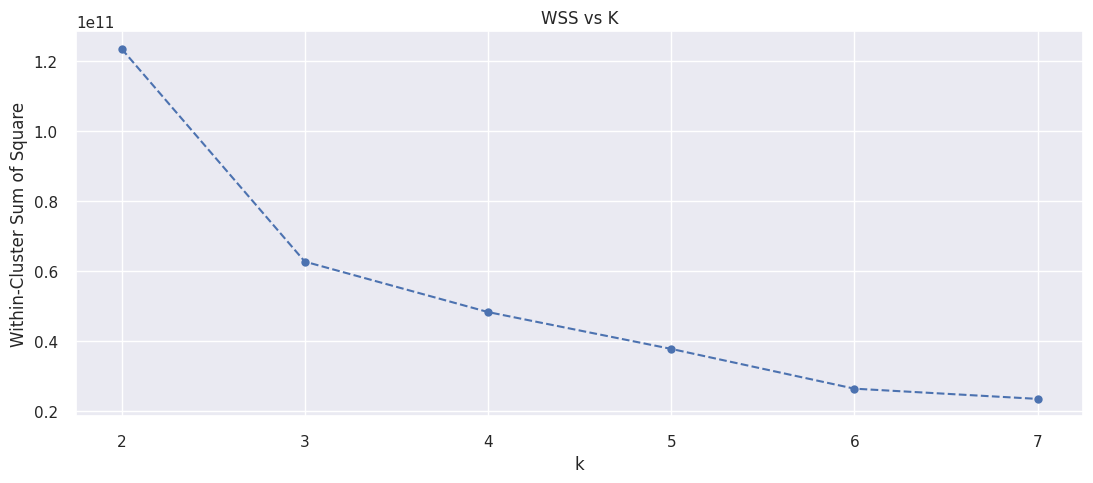

In [317]:
wss = []
for k in cluster:
    #model definition
    kmeans = KMeans(init = 'random',n_clusters = k, n_init = 10, max_iter = 300, random_state = 42)
    #model traning
    kmeans.fit(x)
    #validation
    wss.append(kmeans.inertia_)

#plt SWW - Elbow Method
plt.plot(cluster, wss, linestyle = '--', marker = 'o', color = 'b')
plt.title('WSS vs K')
plt.xlabel('k')
plt.ylabel('Within-Cluster Sum of Square')
plt.show()

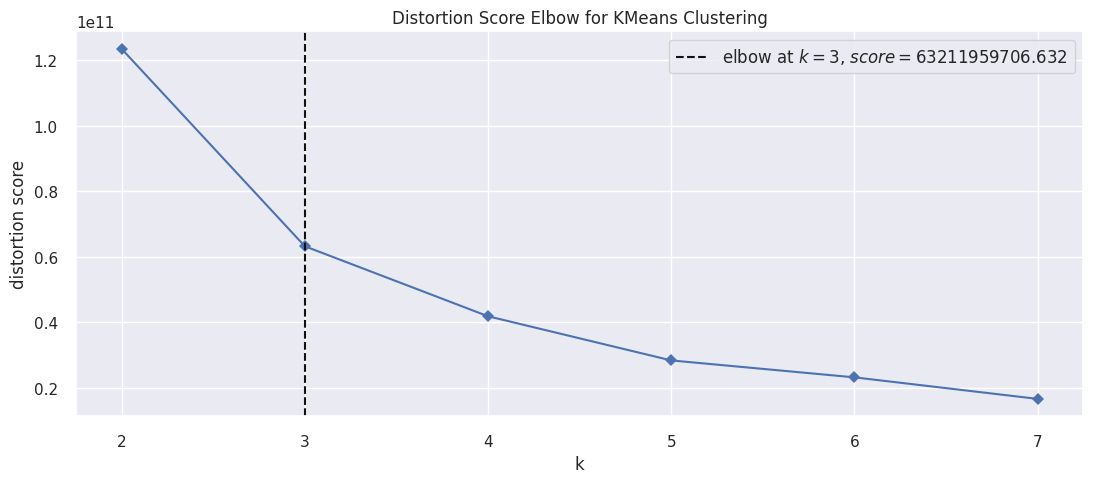

In [318]:
kmeans = KElbowVisualizer(KMeans(), k = cluster, timings = False)
kmeans.fit(x)
kmeans.show();


## 8.2 - SILHOUETT SCORE

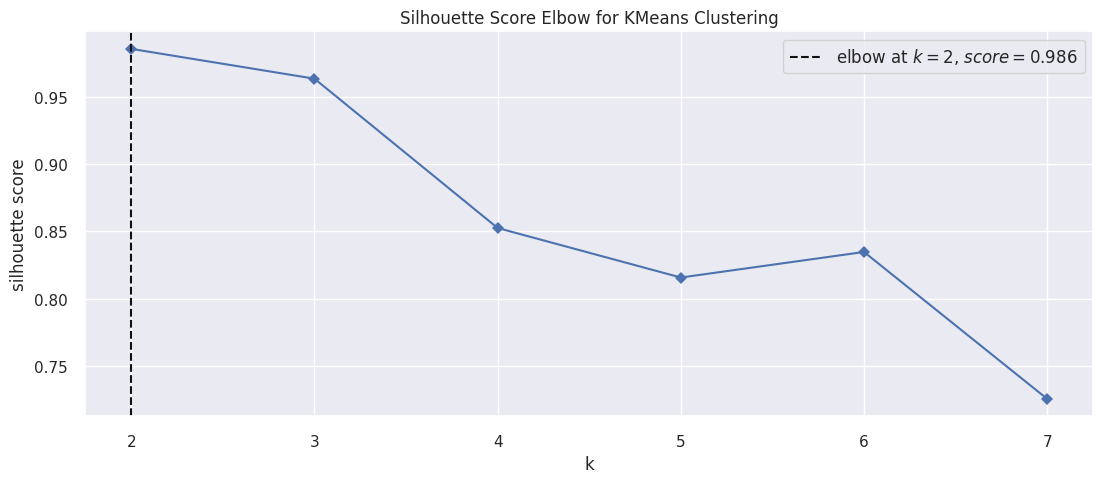

In [319]:
kmeans = KElbowVisualizer(KMeans(), k = cluster, timings = False, metric='silhouette', timing = 'fit')
kmeans.fit(x)
kmeans.show();

## 8.3 - SILHOUETTE ANALYSIS

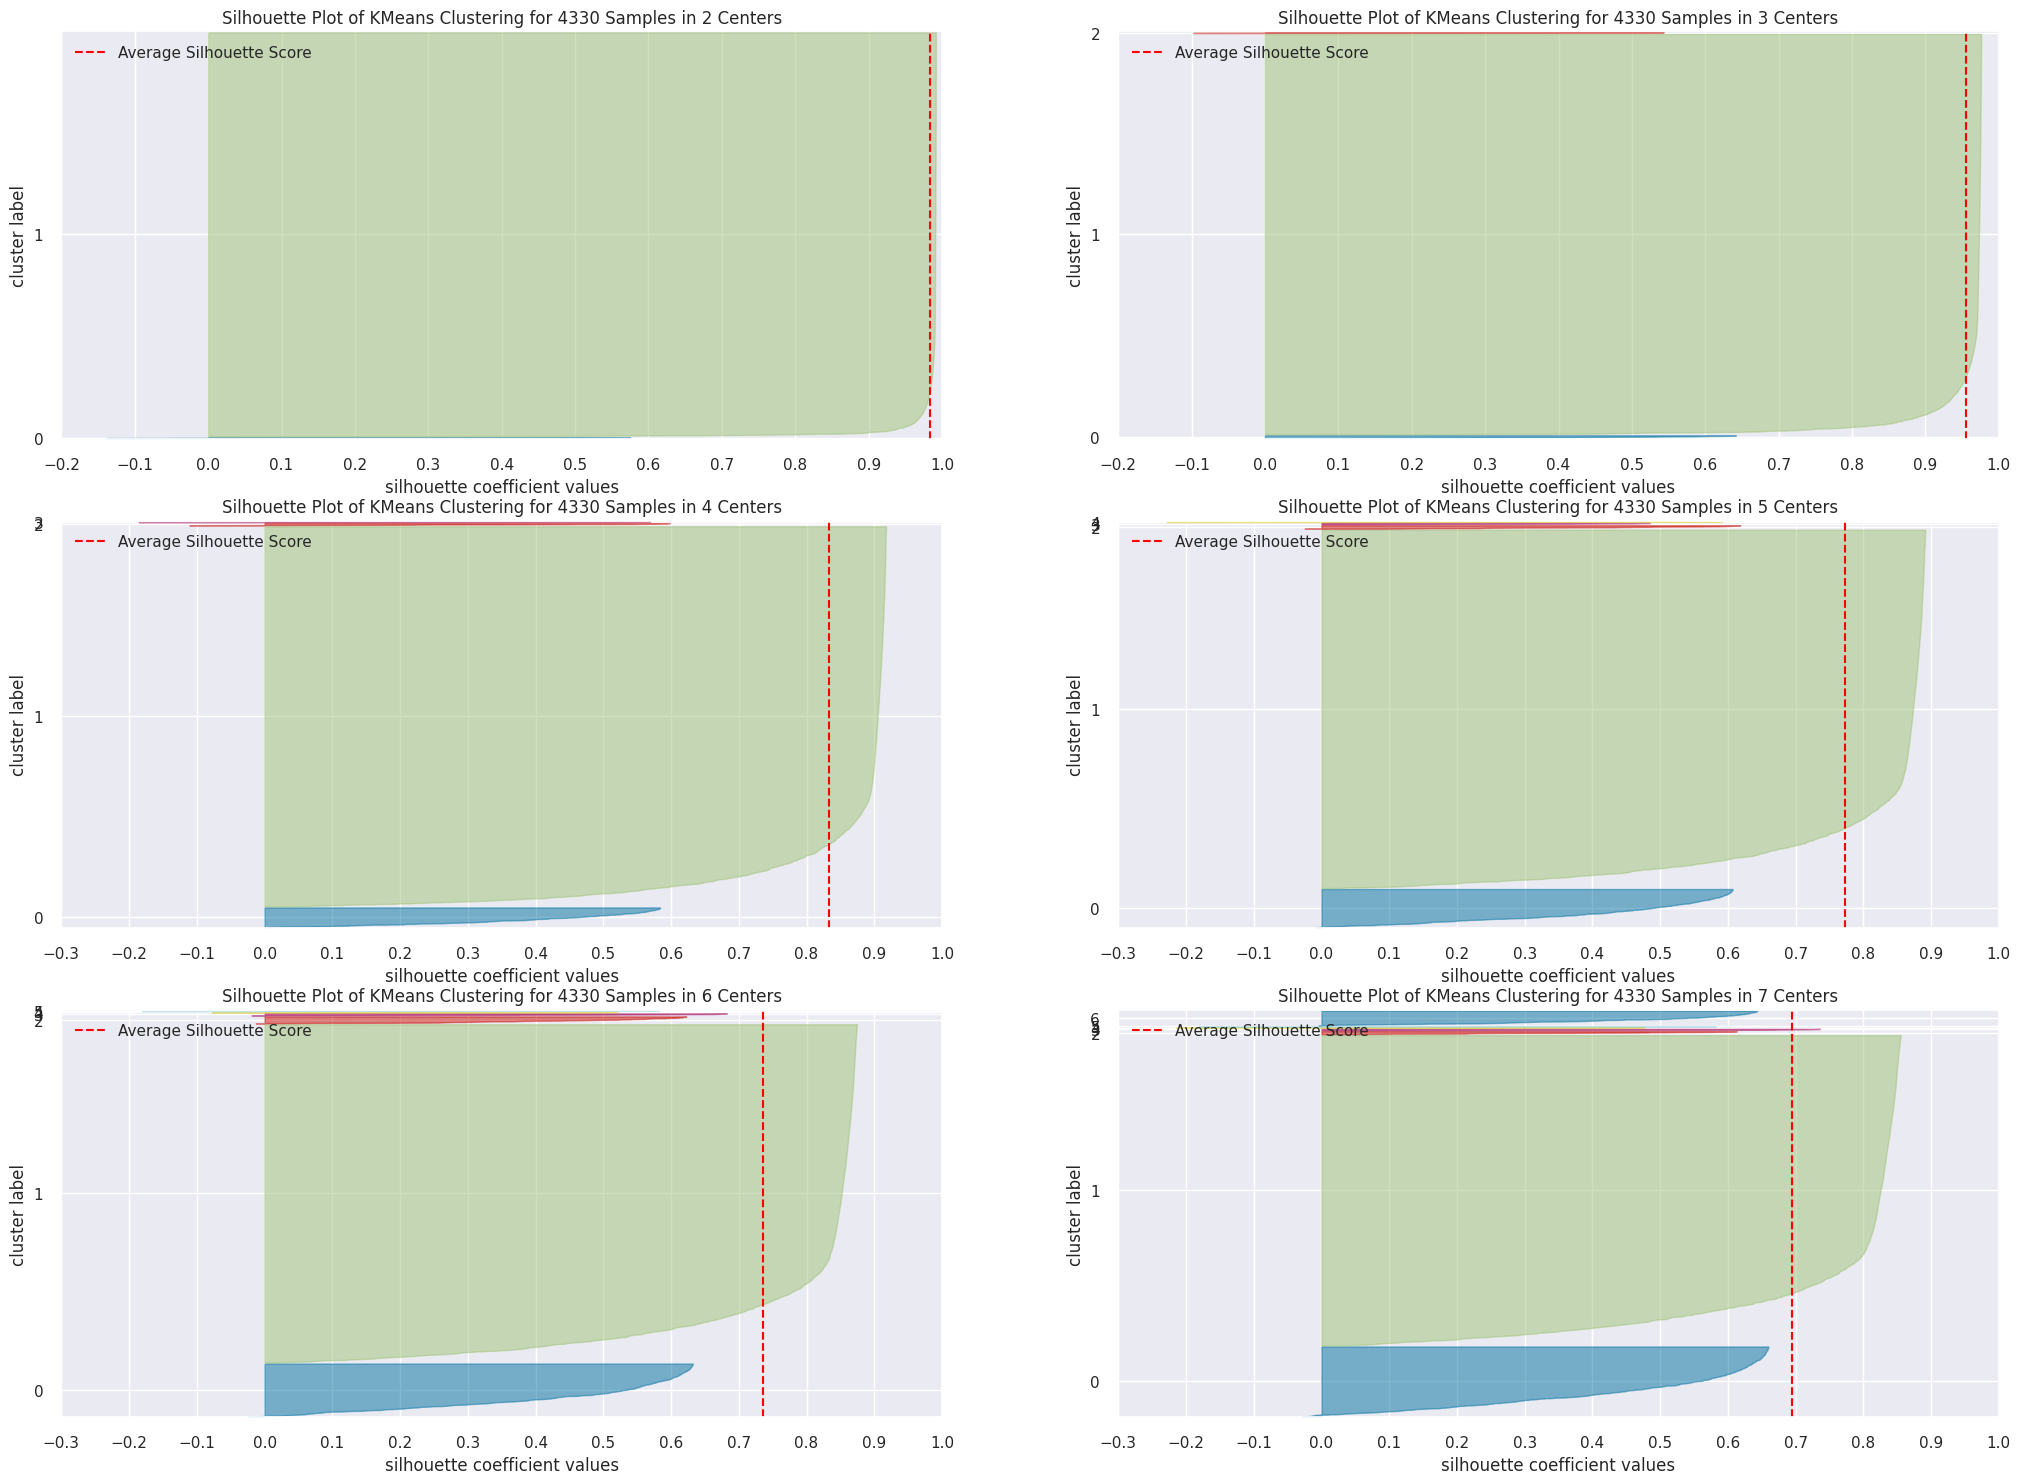

In [320]:
fig, ax = plt.subplots(3, 2, figsize = (25, 18) )
k = list(range(2,8))
for k in cluster:
    q, mod = divmod(k, 2)
    kmeans = KMeans(init = 'random', n_clusters = k, n_init = 10, max_iter = 100, random_state = 42)
    visualizer = SilhouetteVisualizer(kmeans, colors = 'yellowbrick', ax = ax[q-1][mod])
    visualizer.fit(x)
    visualizer.finalize()

# 9.0 - MACHINE LEARNING MODEL

## 9.1 - K-MEANS

In [321]:
#model definition
k = 5
kmeans = KMeans(init = 'random', n_clusters = k, n_init = 10, max_iter = 300, random_state = 42)

#model training
kmeans.fit(x)

#clustering
labels = kmeans.labels_

## 9.2 - CLUSTER PERFOMANCE

In [322]:
print('WSS Value: {}'.format(kmeans.inertia_))
print('Silhouette Score Value: {}'.format(silhouette_score(x, labels, metric = 'euclidean')))

WSS Value: 37802572383.82935
Silhouette Score Value: 0.7732504957423869


# 10.0 - CLUSTER ANALYSIS

In [323]:
df9 = df6.copy()
df9['cluster'] = labels
df9.head(10)

,customer_id,gross_revenue,recency_days,invoice_no,avg_ticket,cluster
0,17850,5391.21,371.0,34.0,18.152222,0
1,13047,3232.59,56.0,9.0,18.904035,1
2,12583,6705.38,2.0,15.0,28.902500,0
3,13748,948.25,95.0,5.0,33.866071,1
4,15100,876.00,333.0,3.0,292.000000,1
5,15291,4623.30,25.0,14.0,45.326471,0
6,14688,5630.87,7.0,21.0,17.219786,0
7,17809,5411.91,15.0,12.0,88.719836,0
8,15311,60767.90,0.0,91.0,25.543464,3
9,16098,2005.63,87.0,7.0,29.934776,1


## 10.1 - VISUALIZATION INSPECTION

/home/erickvieira/.pyenv/versions/3.11.7/envs/clusteringvenv/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(


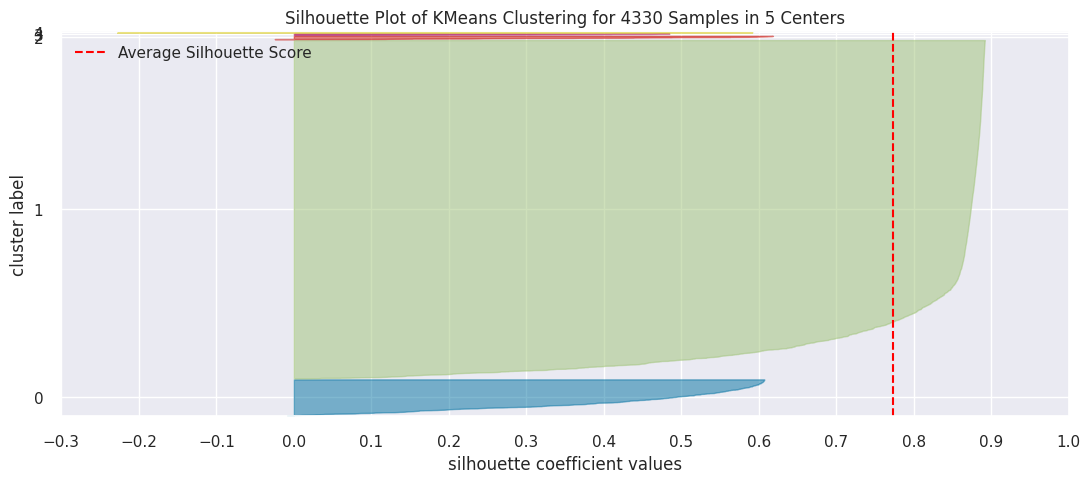

In [324]:
visualizer = SilhouetteVisualizer(kmeans, colors = 'yellowbrick')
visualizer.fit(x)
visualizer.finalize()

## 10.2 - 2D PLOT

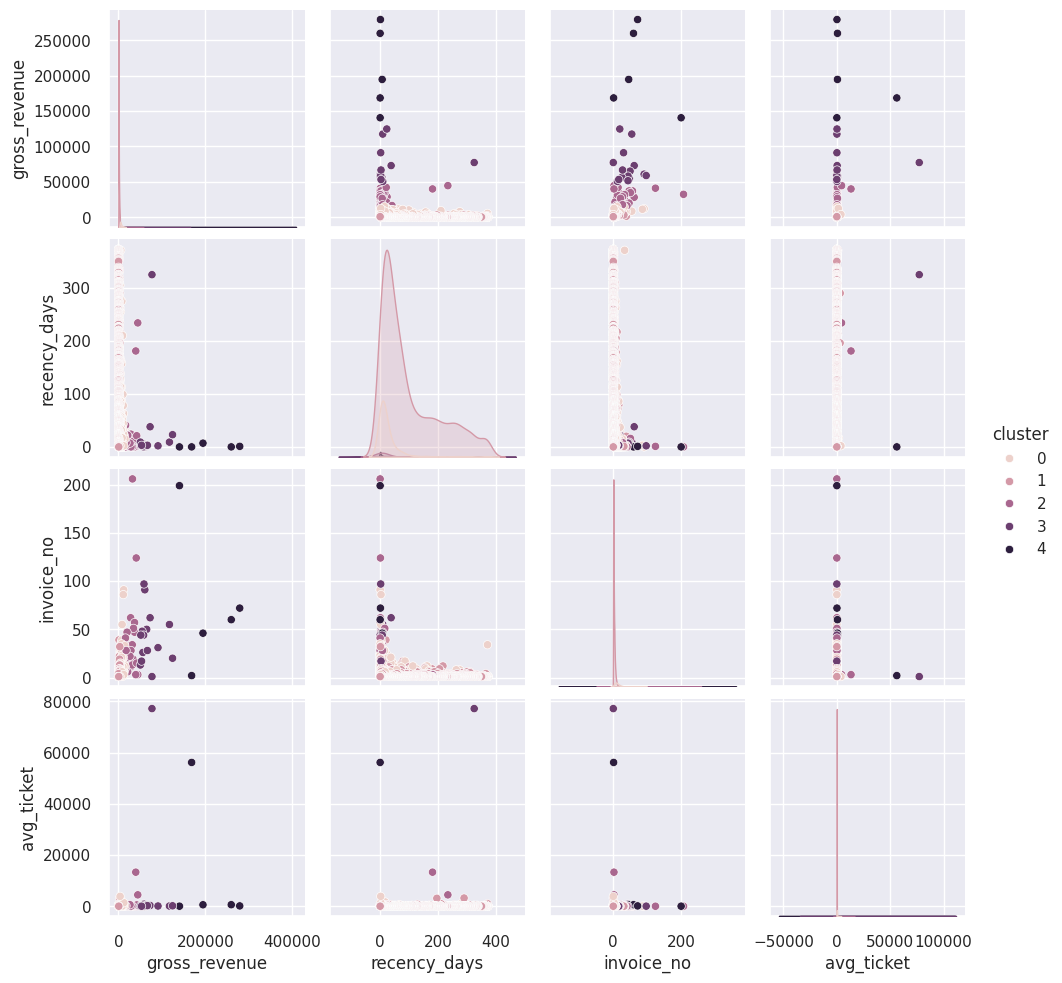

In [325]:
df_viz = df9.drop(columns = 'customer_id', axis = 1)
sns.pairplot(df_viz, hue = 'cluster')
plt.show()

## 10.3 - UMAP - HIGH DIMENSIONALITY

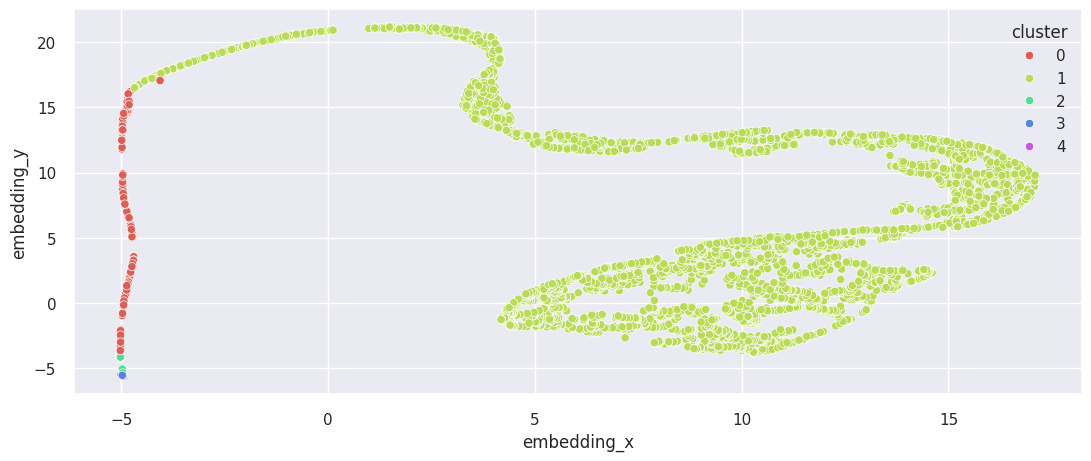

In [326]:
reducer = umap.UMAP(random_state = 42, n_neighbors = 20, n_jobs = 1)
embedding = reducer.fit_transform(x)

#embedding
df_viz['embedding_x'] = embedding[:, 0]
df_viz['embedding_y'] = embedding[:, 1]

#plot

sns.scatterplot(data = df_viz, x = 'embedding_x', y = 'embedding_y', 
                hue = 'cluster', 
                palette = sns.color_palette( 'hls', n_colors = len(df_viz['cluster'].unique())))

plt.show()

## 10.4 - CLUSTER PROFILE

In [327]:
df9.sample(5)

,customer_id,gross_revenue,recency_days,invoice_no,avg_ticket,cluster
3216,14720,663.81,5.0,3.0,17.940811,1
2899,15014,260.17,42.0,2.0,7.433429,1
4219,17636,285.56,18.0,1.0,14.278000,1
3935,17712,522.91,44.0,1.0,18.031379,1
3677,12789,76.85,64.0,1.0,25.616667,1


In [328]:
# Percentual of customers of each cluster
df_cluster = df9[['customer_id','cluster']].groupby('cluster')['customer_id'].count().reset_index().rename(columns = {'customer_id': 'total_customer'})
df_cluster['percentual_customer'] = (df_cluster['total_customer'] / df_cluster['total_customer'].sum()) * 100

#avg gross revenue
df_gross_revenue = df9[['gross_revenue', 'cluster']].groupby('cluster')['gross_revenue'].mean().reset_index()
df_cluster = pd.merge(df_cluster, df_gross_revenue, on = 'cluster', how = 'inner')

#avg recency_days
df_recency_days = df9[['cluster', 'recency_days']].groupby('cluster')['recency_days'].mean().reset_index()
df_cluster = pd.merge(df_cluster, df_recency_days , on = 'cluster', how = 'inner')

#invoice number
df_invoice_no= df9[['cluster', 'invoice_no']].groupby('cluster')['invoice_no'].mean().reset_index()
df_cluster = pd.merge(df_cluster, df_invoice_no, on = 'cluster', how = 'inner')

#avg ticket
df_avg_ticket= df9[['cluster', 'avg_ticket']].groupby('cluster')['avg_ticket'].mean().reset_index()
df_cluster = pd.merge(df_cluster, df_avg_ticket, on = 'cluster', how = 'inner')

df_cluster['percentual_customer'] = df_cluster['percentual_customer'].apply(lambda x: np.round(x, 2))
df_cluster['percentual_customer'] = df_cluster['percentual_customer'].astype(str)
df_cluster['percentual_customer'] = df_cluster['percentual_customer'].apply(lambda x: x + '%')
df_cluster['recency_days'] = df_cluster['recency_days'].astype(int)
df_cluster['invoice_no'] = df_cluster['invoice_no'].astype(int)

df_cluster['gross_revenue'] = df_cluster['gross_revenue'].apply(lambda x: "${:,.2f}".format(x))
df_cluster['avg_ticket'] = df_cluster['avg_ticket'].apply(lambda x: "${:,.2f}".format(x))

new_order_comuns = ['total_customer', 'cluster', 'percentual_customer', 'recency_days', 'invoice_no', 'gross_revenue', 'avg_ticket']
df_cluster = df_cluster[new_order_comuns]

df_cluster

,total_customer,cluster,percentual_customer,recency_days,invoice_no,gross_revenue,avg_ticket
0,413,0,9.54%,25,12,"$5,932.36",$60.57
1,3859,1,89.12%,99,2,$843.89,$28.49
2,38,2,0.88%,17,34,"$25,177.08",$585.44
3,15,3,0.35%,28,41,"$70,563.60","$5,319.26"
4,5,4,0.12%,1,75,"$208,453.87","$11,499.50"


CLUSTER 01: (Program Candidate High Value Customer)
 - Total of customers: 6 (0.14% of customers)
 - Average of Recency Days: 6
 - Average of invoice number: 89
 - Average of Gross Revenue: $182.181,98
 - Average of Average Ticket: $253.63

 CLUSTER 02:
 - Total of customers: 28 (0.64% of customers)
 - Average of Recency Days: 5
 - Average of invoice number: 57
 - Average of Gross Revenue: $42,614.39
 - Average of Average Ticket: $162.86

 CLUSTER 03:
 - Total of customers: 4071 (93.12% of customers)
 - Average of Recency Days: 96
 - Average of invoice number: 3
 - Average of Grossa Revenue: $946.70
 - Average of Average Ticket: $25.36

CLUSTER 04:
 - Total of customers: 267 (6.11% of customers)
 - Average of Recency Days: 19
 - Average of invoice number: 19
 - Average of Gross Revenue: $8,089.03
 - Average of Average Ticket: $62.78
